In [1]:
import os
import numpy as np
import pandas as pd
import urllib.parse
from urllib.parse import unquote
import pickle
import scipy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

platform = "vscode"
if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    data_dir = '/content/drive/MyDrive/wikispeedia_data/wikispeedia_paths-and-graph/' #@param {type:"string"}
    dependencies_dir = '/content/drive/MyDrive/wikispeedia_data/' #@param {type:"string"}
else:
    data_dir = os.path.join(os.getcwd(), 'dependencies', 'wikispeedia_paths-and-graph')
    dependencies_dir = os.path.join(os.getcwd(), 'dependencies')

This Notebook will contain the following:
1. LLM Description
2. Zoomout - Zoomin analysis

# 1. LLM DESCRIPTION

Since our project involves letting the 'AI' play the Wikispeedia game, we need to find an LLM that is able to play by following the commands. The best and first choice would have been **ChatGPT** with the *OpenAI - API*. However, our choice is restricted by resources (both computational and economical). Hence, we rescricted the scope of our research to the models with less than 13B parameters publicly available on the *HuggingFace* repository. After looking at the HF leaderboard, we focused on the following three models:

2. **LlaMA-13B**    (see the model on [hugging-face](https://huggingface.co/meta-llama/Llama-2-13b-hf))
3. **Mistral-7B**   (see the model on [hugging-face](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2))

Note that: for all these models, we selected the *instruct* version, which means that the model is trained to follow instructions.

While LlaMA-13B has more parameters than Mistral-7B, it was not performing as good (as the results from Jiang, Albert Q., et al. "Mistral 7B" arXiv preprint arXiv:2310.06825 (2023) are also proving): 

![image.png](dependencies/MISTRALvsLLaMA_hist.png)

![image.png](dependencies/MISTRALvsLLaMA_table.png)

# 2. ZOOMOUT - ZOOMIN ANALYSIS

## Load Human Games

In [2]:
# decode url text inside page names
def decode_list(url_encoded_list):
    """Decodes url_encoded path.
    
    Args:
        url_encoded_list (list): list of url_encoded page names
    
    Returns:
        list: list of decoded page names
    """
    return [urllib.parse.unquote(element).replace(',', '') for element in url_encoded_list]

# pull in finished games and prepare for append
human_fin = pd.read_csv(os.path.join(data_dir, 'paths_finished.tsv'), sep='\t', skiprows = 16, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
human_fin['path_decoded'] = human_fin['path'].str.split(';').apply(decode_list)
human_fin['origin'] = human_fin['path_decoded'].str[0]
human_fin['goal'] = human_fin['path_decoded'].str[-1]
human_fin['finished'] = 1

# pull in unfinished games and prepare for append
human_unfin = pd.read_csv(os.path.join(data_dir, 'paths_unfinished.tsv'), sep='\t', skiprows=17, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
human_unfin['path_decoded'] = human_unfin['path'].str.split(';').apply(decode_list)
human_unfin['origin'] = human_unfin['path_decoded'].str[0]
human_unfin = human_unfin.rename(columns={'target': 'goal'})
human_unfin['finished'] = 0

# append
human = pd.concat([human_fin, human_unfin])
human['game_pair'] = human['origin'] + "->" + human['goal']
human['player_type'] = "human"
human = human[['player_type'] + [col for col in list(human.columns) if col != 'player_type']]
human.head()

# intra game-pair and timestamp index (for global id later)
human.sort_values(by=['game_pair', 'timestamp'], inplace=True)
human['iteration'] = human.groupby('game_pair').cumcount()
human.head()

,player_type,hashedIpAddress,timestamp,durationInSec,path,rating,path_decoded,origin,goal,finished,type,game_pair,iteration
29758,human,516b61133d358ce1,1224623308,6,10th_century;11th_century,1.0,"[10th_century, 11th_century]",10th_century,11th_century,1,NaN,10th_century->11th_century,0
29759,human,6b039e9953cf075e,1241187124,3,10th_century;11th_century,5.0,"[10th_century, 11th_century]",10th_century,11th_century,1,NaN,10th_century->11th_century,1
29760,human,0aecf97906bcb41a,1373439892,4,10th_century;11th_century,1.0,"[10th_century, 11th_century]",10th_century,11th_century,1,NaN,10th_century->11th_century,2
29761,human,32652d6d1c5d9351,1260397548,48,10th_century;Maya_civilization;Silver;Coin;Ban...,3.0,"[10th_century, Maya_civilization, Silver, Coin...",10th_century,Banknote,1,NaN,10th_century->Banknote,0
29753,human,0d57c8c57d75e2f5,1296192247,15,10th_century;Germany;Country,1.0,"[10th_century, Germany, Country]",10th_century,Country,1,NaN,10th_century->Country,0


## Load Mistral Games and Conform to Human Structure

In [4]:
# open mistral data and cast as df via properly formatted nested list
with open('Mistral_7B_Games/Mistral_Games.pickle', 'rb') as file:
    mistral_nested_dict = pickle.load(file)
list_of_lists = []
for key in mistral_nested_dict:
    for i in range(len(mistral_nested_dict[key])):
        list_of_lists.append([key, mistral_nested_dict[key][f'rep{i}'], i])
mistral = pd.DataFrame(list_of_lists, columns=['game_pair', 'path_decoded', 'iteration'])

# conform to human data structure
mistral['origin'] = mistral['game_pair'].str.split("->").str[0]
mistral['goal'] = mistral['game_pair'].str.split("->").str[1]
mistral['finished'] = mistral.apply(lambda row: 1 if row['goal'] == row['path_decoded'][-1] else 0, axis=1)
mistral['path_decoded'] = mistral.apply(lambda row: [row['origin']] + row['path_decoded'], axis=1)
mistral['player_type'] = "mistral"
mistral = mistral[['player_type'] + [col for col in list(mistral.columns) if col != 'player_type']]
mistral.head()

,player_type,game_pair,path_decoded,iteration,origin,goal,finished
0,mistral,Brain->Telephone,"[Brain, Computer_science, Computer_programming...",0,Brain,Telephone,1
1,mistral,Brain->Telephone,"[Brain, Computer_science, Computer_programming...",1,Brain,Telephone,1
2,mistral,Brain->Telephone,"[Brain, Computer_science, Information, Communi...",2,Brain,Telephone,1
3,mistral,Brain->Telephone,"[Brain, Computer_science, Information, Communi...",3,Brain,Telephone,1
4,mistral,Brain->Telephone,"[Brain, Computer_science, Information, Communi...",4,Brain,Telephone,1


## Create global games dataset

In [5]:
# concat
all_game_paths = pd.concat([human, mistral])[['player_type', 'path_decoded', 'origin', 'goal', 'finished', 'game_pair', 'iteration']].reset_index(drop=True)

# unique id
all_game_paths['unique_path_id'] = all_game_paths.apply(lambda row: row['player_type'] + "_" + row['game_pair'] + "_" + str(row['iteration']), axis = 1).apply(hash).apply(abs)
all_game_paths = all_game_paths.drop(columns=['iteration'])
all_game_paths = all_game_paths[['unique_path_id'] + [col for col in list(all_game_paths.columns) if col != 'unique_path_id']]
if all_game_paths['unique_path_id'].duplicated().any() == False:
    all_game_paths.to_csv("dependencies/all_game_paths.csv")
else:
    print("global id not unique - alter creation")
all_game_paths.head()

,unique_path_id,player_type,path_decoded,origin,goal,finished,game_pair
0,8829654559018126637,human,"[10th_century, 11th_century]",10th_century,11th_century,1,10th_century->11th_century
1,5115913342958724715,human,"[10th_century, 11th_century]",10th_century,11th_century,1,10th_century->11th_century
2,4332275554086265033,human,"[10th_century, 11th_century]",10th_century,11th_century,1,10th_century->11th_century
3,7266596437468436759,human,"[10th_century, Maya_civilization, Silver, Coin...",10th_century,Banknote,1,10th_century->Banknote
4,5192076430901207990,human,"[10th_century, Germany, Country]",10th_century,Country,1,10th_century->Country


## Isolate only those games mistral played

In [6]:
mistral_game_pairs = pd.DataFrame(all_game_paths[all_game_paths['player_type'] == 'mistral']['game_pair'].value_counts().index)
relevant_paths = pd.merge(all_game_paths, mistral_game_pairs, on='game_pair')

In [8]:
# the goal now is to investigate the zoom-out zoom-in effect for the two player types. The zoom-out zoom-in effect 
# means that the player navigates first to paths that have a large number of outgoing degrees to reach an 'hub'
# that is then used to navigate to the goal. The zoom-out zoom-in effect is a consequence of the small-world 
# phenomenon.

# To investigate the zoom-out zoom-in effect, we can do the following:
# 1. For each path, calculate the number of outgoing degrees for each page in the path. If the zoom-out zoom-in
#    effect is present, we expect to see a large number of outgoing degrees among the first pages in the path.
# 2. Compute which pages are hubs. Then check if the hubs are used to navigate to the goal. If the zoom-out zoom-in
#    effect is present, we expect to see a large number of hubs inside the path.


In [ ]:
import pandas as pd
from collections import Counter
from helpers import get_links_from_wikipedia_page

# Sample function to calculate outgoing degrees for each page in a path
def calculate_outgoing_degrees(path):
    outgoing_degrees = Counter()
    for page in path:
        # Assuming you have a way to get outgoing connections for each page
        # Replace get_outgoing_degrees(page) with your own function to retrieve outgoing degrees
        outgoing_connections = get_links_from_wikipedia_page(page)
        outgoing_degrees[page] = len(outgoing_connections)
    return outgoing_degrees

# Assuming all_game_paths is your DataFrame containing the data
# Assuming path_decoded column contains the paths as lists of pages

# Apply the function to calculate outgoing degrees for each path
all_game_paths['outgoing_degrees'] = all_game_paths['path_decoded'].apply(calculate_outgoing_degrees)


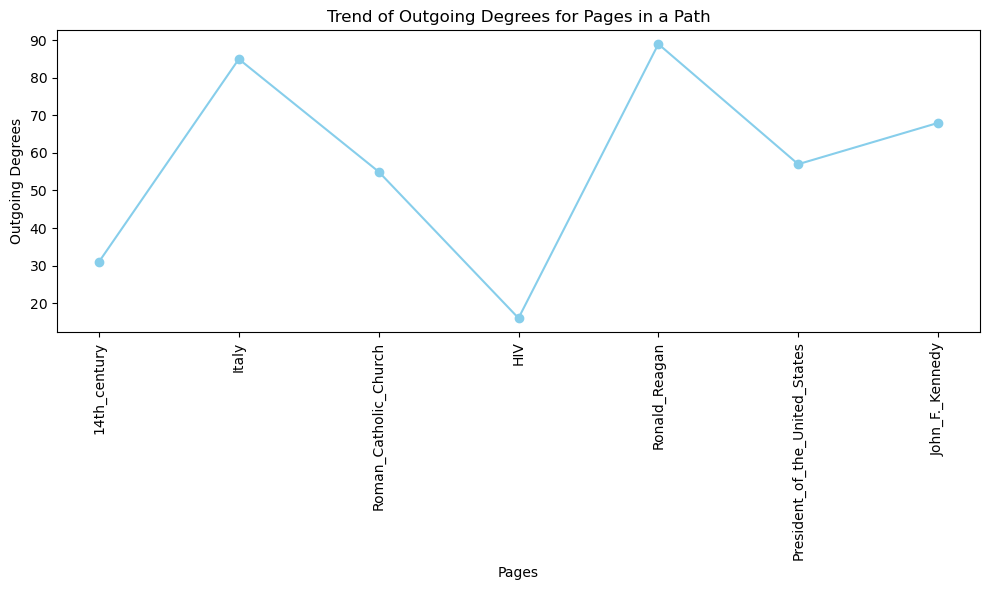

In [18]:
import matplotlib.pyplot as plt

# Function to plot outgoing degrees for a single path as a line plot
def plot_outgoing_degrees_line(path_outgoing_degrees):
    pages = list(path_outgoing_degrees.keys())
    degrees = list(path_outgoing_degrees.values())

    plt.figure(figsize=(10, 6))
    plt.plot(pages, degrees, marker='o', linestyle='-', color='skyblue')
    plt.xlabel('Pages')
    plt.ylabel('Outgoing Degrees')
    plt.title('Trend of Outgoing Degrees for Pages in a Path')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Choose a path (for example, the first path in the DataFrame)
sample_path_outgoing_degrees = all_game_paths['outgoing_degrees'][90]

# Plot outgoing degrees for the selected path as a line plot
plot_outgoing_degrees_line(sample_path_outgoing_degrees)


In [14]:
all_game_paths

,unique_path_id,player_type,path_decoded,origin,goal,finished,game_pair,outgoing_degrees
0,8829654559018126637,human,"[10th_century, 11th_century]",10th_century,11th_century,1,10th_century->11th_century,"{'10th_century': 26, '11th_century': 48}"
1,5115913342958724715,human,"[10th_century, 11th_century]",10th_century,11th_century,1,10th_century->11th_century,"{'10th_century': 26, '11th_century': 48}"
2,4332275554086265033,human,"[10th_century, 11th_century]",10th_century,11th_century,1,10th_century->11th_century,"{'10th_century': 26, '11th_century': 48}"
3,7266596437468436759,human,"[10th_century, Maya_civilization, Silver, Coin...",10th_century,Banknote,1,10th_century->Banknote,"{'10th_century': 26, 'Maya_civilization': 42, ..."
4,5192076430901207990,human,"[10th_century, Germany, Country]",10th_century,Country,1,10th_century->Country,"{'10th_century': 26, 'Germany': 169, 'Country'..."
...,...,...,...,...,...,...,...,...
78691,2285084566510126118,mistral,"[Apple, Fruit]",Apple,Fruit,1,Apple->Fruit,"{'Apple': 68, 'Fruit': 41}"
78692,958176560485084851,mistral,"[Apple, Fruit]",Apple,Fruit,1,Apple->Fruit,"{'Apple': 68, 'Fruit': 41}"
78693,5604681060688216141,mistral,"[Apple, Fruit]",Apple,Fruit,1,Apple->Fruit,"{'Apple': 68, 'Fruit': 41}"
78694,5607657511120184967,mistral,"[Apple, Fruit]",Apple,Fruit,1,Apple->Fruit,"{'Apple': 68, 'Fruit': 41}"
